In [248]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [249]:
data = pd.read_excel("Raw Dataset.xlsx")
data.head(5)

,Count_point_id,Direction_of_travel,Year,Count_date,Unix Time,hour,Region_name,Local_authority_id,Local_authority_name,Local_authority_code,...,Longitude,Link_length_km,Link_length_miles,Pedal_cycles,Two_wheeled_motor_vehicles,Cars_and_taxis,Buses_and_coaches,LGVs,All_HGVs,All_motor_vehicles
0,37706,E,2008,2008-03-14,1205452800,7,London,109,Westminster,E09000033,...,-0.142301,0.2,0.12,20,48,817,18,409,96,1388
1,37706,E,2008,2008-03-14,1205452800,8,London,109,Westminster,E09000033,...,-0.142301,0.2,0.12,35,52,839,36,309,101,1337
2,37706,E,2008,2008-03-14,1205452800,9,London,109,Westminster,E09000033,...,-0.142301,0.2,0.12,23,63,775,32,232,93,1195
3,37706,E,2008,2008-03-14,1205452800,10,London,109,Westminster,E09000033,...,-0.142301,0.2,0.12,14,53,760,31,339,88,1271
4,37706,E,2008,2008-03-14,1205452800,11,London,109,Westminster,E09000033,...,-0.142301,0.2,0.12,22,76,755,43,393,104,1371


# Data Preprocessing

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85176 entries, 0 to 85175
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Count_point_id              85176 non-null  int64         
 1   Direction_of_travel         85176 non-null  object        
 2   Year                        85176 non-null  int64         
 3   Count_date                  85176 non-null  datetime64[ns]
 4   Unix Time                   85176 non-null  int64         
 5   hour                        85176 non-null  int64         
 6   Region_name                 85176 non-null  object        
 7   Local_authority_id          85176 non-null  int64         
 8   Local_authority_name        85176 non-null  object        
 9   Local_authority_code        85176 non-null  object        
 10  Road_name                   85176 non-null  object        
 11  Road_category               85176 non-null  object    

There are 4 variables with an extremely high count of null values: Start_junction_road_name, End_junction_road_name, Link_length_km and Link_length_miles. We decide to drop these from our analysis.

We also decide to drop the following unneeded columns (reasons given):
1. Count_point_id - this isn't a feature we want to explore
2. Direction_of_travel - this is redundant, as we already have the columns 'Easting' and 'Northing'
3. Year and Count_date - these columns are redundant as we derived the column 'Unix Time' using the 'Count_date' column, because it is of int datatype and thus easier to work with
4. Region_name - we only have one region i.e. London, so this column does not help
5. Local_authority_name and Local_authority_code - these are redundant columns as we can just keep Local_authority_id instead, which is integer data
6. Road_name - we have the specific location of measurement in latitudes and longitudes so this is not needed

In [251]:
data_cleaned = data.drop(columns=['Year','Count_point_id','Direction_of_travel','Count_date','Region_name',
                                  'Local_authority_name','Local_authority_code','Start_junction_road_name', 
                                  'End_junction_road_name', 'Link_length_km', 'Link_length_miles','Road_name'])
data_cleaned.shape

(85176, 16)

In [252]:
# Dropping rows with any missing values
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(85176, 16)

We don't have any null values in our data now. Let us check for outliers.

In [253]:
df = data_cleaned[['hour','Latitude','Longitude','Pedal_cycles','Two_wheeled_motor_vehicles','Cars_and_taxis','Buses_and_coaches','LGVs','All_HGVs','All_motor_vehicles']]
df

,hour,Latitude,Longitude,Pedal_cycles,Two_wheeled_motor_vehicles,Cars_and_taxis,Buses_and_coaches,LGVs,All_HGVs,All_motor_vehicles
0,7,51.497650,-0.142301,20,48,817,18,409,96,1388
1,8,51.497650,-0.142301,35,52,839,36,309,101,1337
2,9,51.497650,-0.142301,23,63,775,32,232,93,1195
3,10,51.497650,-0.142301,14,53,760,31,339,88,1271
4,11,51.497650,-0.142301,22,76,755,43,393,104,1371
...,...,...,...,...,...,...,...,...,...,...
85171,14,51.391849,-0.262298,1,22,1980,10,458,75,2545
85172,15,51.391849,-0.262298,0,19,1871,11,575,93,2569
85173,16,51.391849,-0.262298,0,65,2803,9,441,63,3381
85174,17,51.391849,-0.262298,2,64,2783,8,398,66,3319


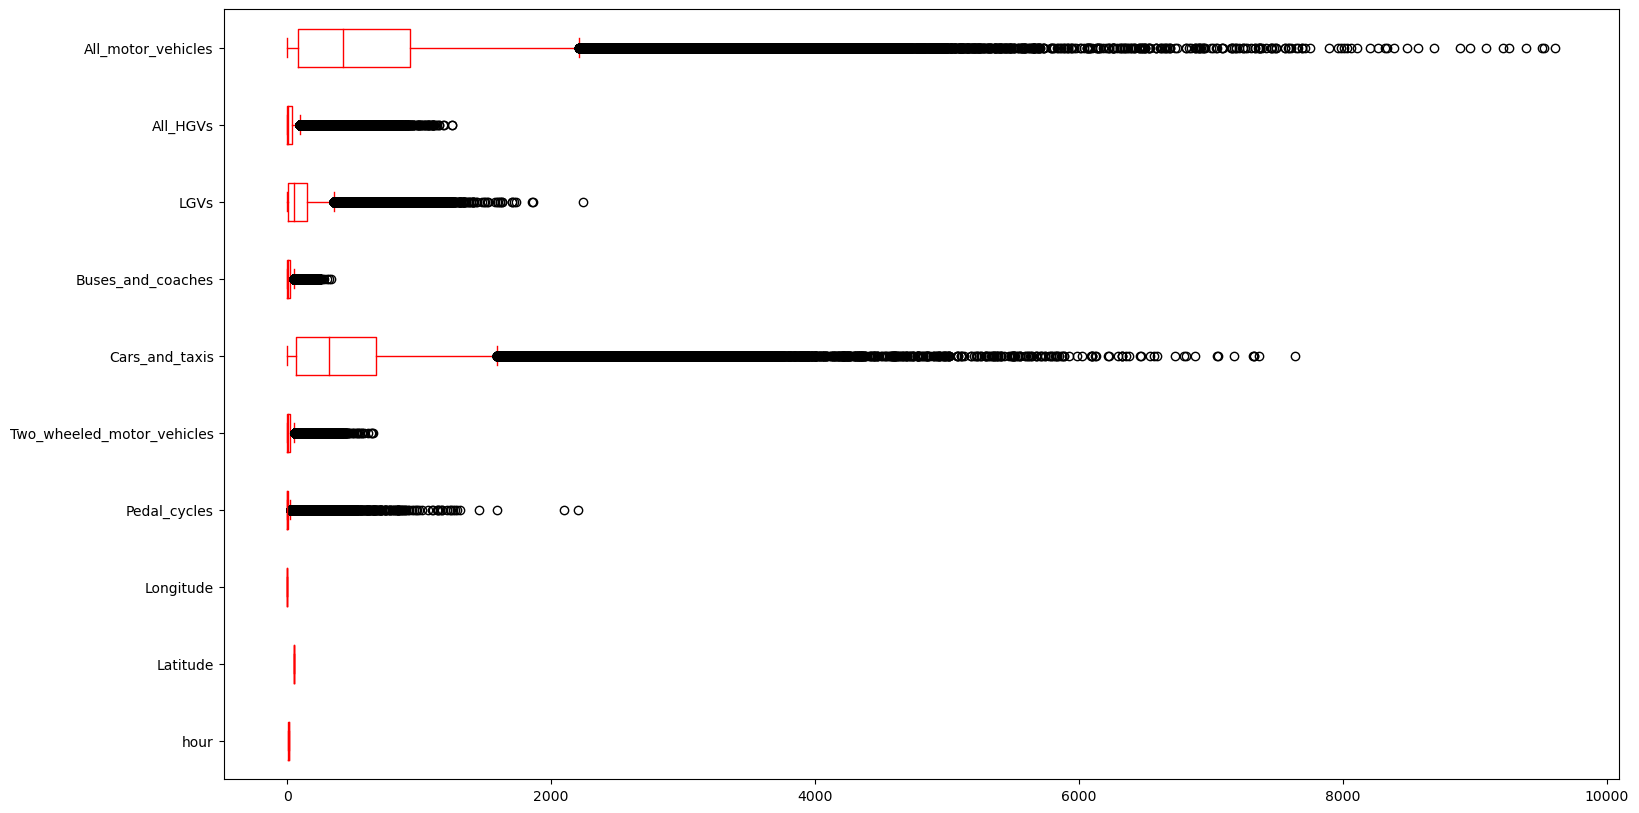

In [254]:
df.plot(kind='box',figsize=(18,10),color='Red',vert=False)
plt.show()

Since there are a vast amount of outliers present in our dataset, we want to remove the most extreme values (as, for example, it is highly improbable that there are almost 8000 cars at a given time; we do not want this to affect our predictions.) 

However, since outliers can still be genuine values, we decide to remove only the most extreme outliers i.e. the ones beyond 3 times the IQR.

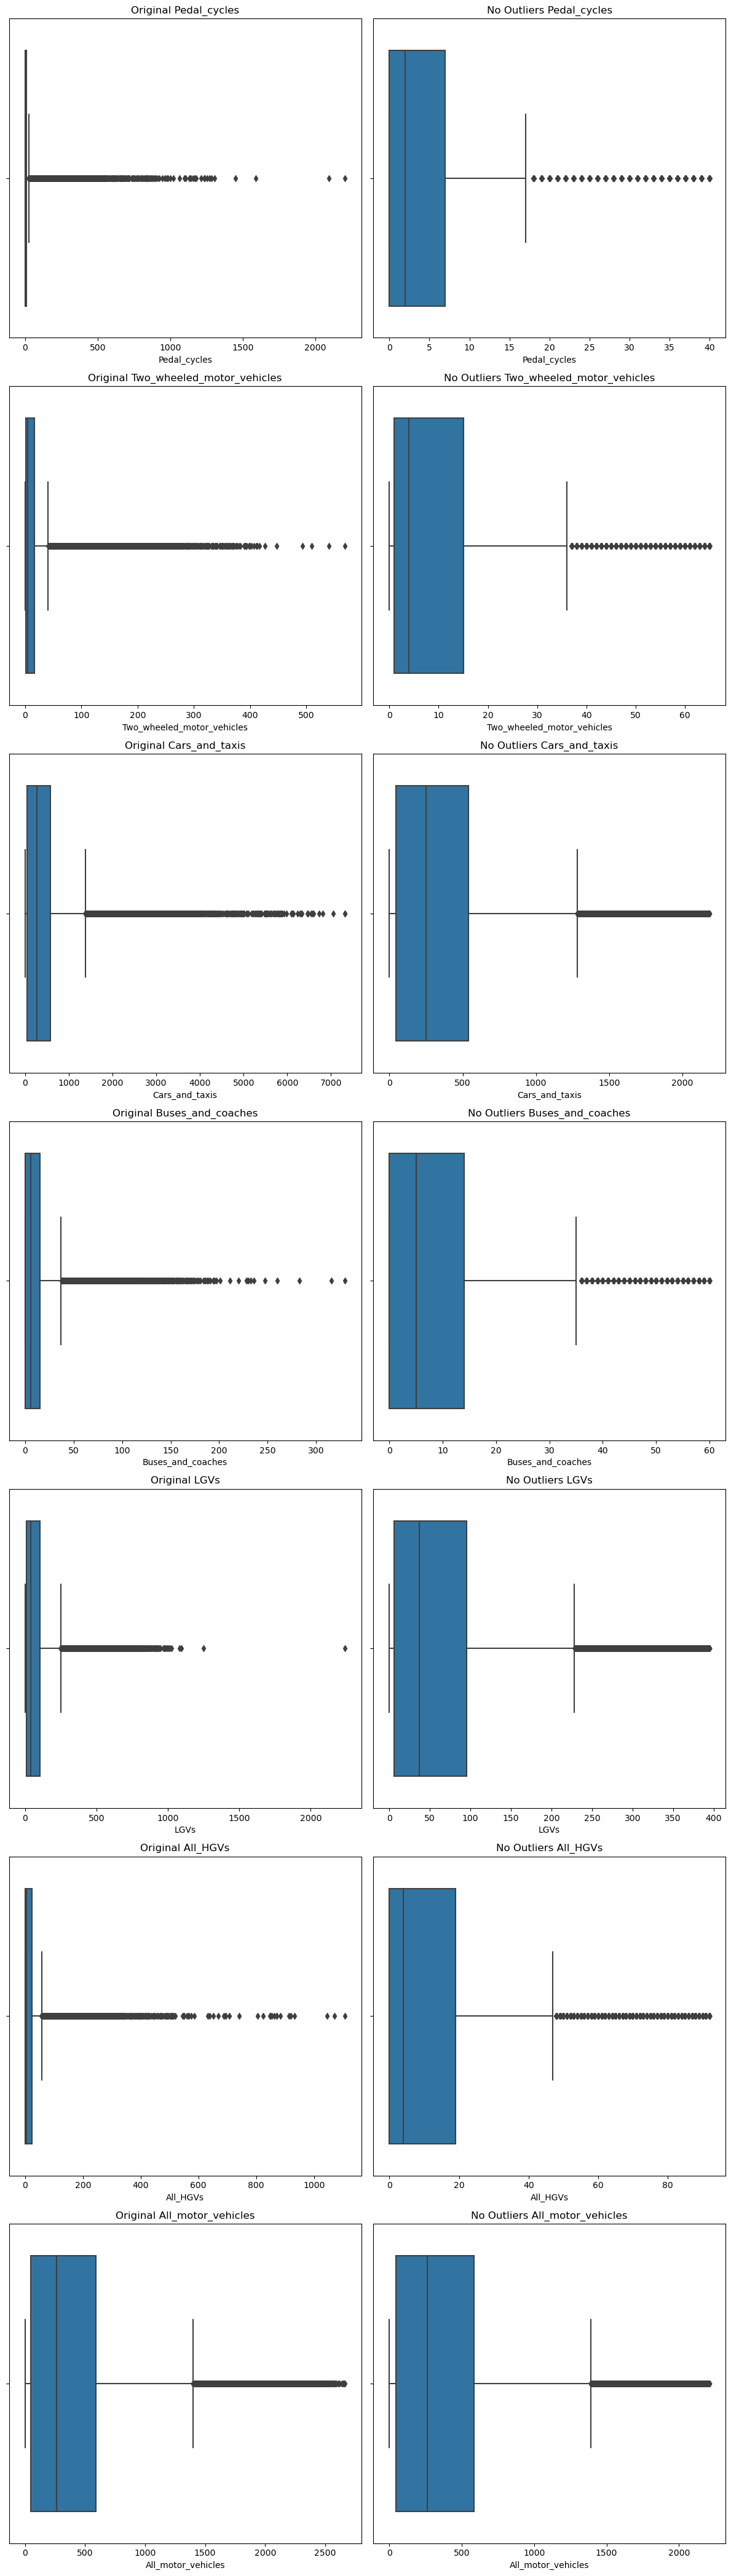

In [255]:
from scipy.stats import iqr

columns_to_remove_outliers = ['Pedal_cycles','Two_wheeled_motor_vehicles', 'Cars_and_taxis', 'Buses_and_coaches', 'LGVs', 'All_HGVs', 'All_motor_vehicles']

fig, axes = plt.subplots(nrows=len(columns_to_remove_outliers), ncols=2, figsize=(12, 6 * len(columns_to_remove_outliers)))

for i, column_name in enumerate(columns_to_remove_outliers):
    sns.boxplot(ax=axes[i, 0], x=data_cleaned[column_name]).set_title(f'Original {column_name}') #plotting the original boxplot
    my_iqr = iqr(data_cleaned[column_name])
    
    lower_bound = data_cleaned[column_name].quantile(0.25) - 3 * my_iqr
    upper_bound = data_cleaned[column_name].quantile(0.75) + 3 * my_iqr

    data_cleaned = data_cleaned[(data_cleaned[column_name] >= lower_bound) & (data_cleaned[column_name] <= upper_bound)] #filtering out the outliers

    sns.boxplot(ax=axes[i, 1], x=data_cleaned[column_name]).set_title(f'No Outliers {column_name}') #boxplots after removing the outliers

plt.tight_layout()
plt.show() 

In [256]:
data_cleaned.describe()

,Unix Time,hour,Local_authority_id,Easting,Northing,Latitude,Longitude,Pedal_cycles,Two_wheeled_motor_vehicles,Cars_and_taxis,Buses_and_coaches,LGVs,All_HGVs,All_motor_vehicles
count,6.482400e+04,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000,64824.000000
mean,1.343179e+09,12.541343,130.432818,528576.520748,178968.752005,51.494929,-0.149234,5.329091,7.311675,298.978048,8.927064,55.002653,13.294952,383.514393
std,1.120974e+08,3.387184,40.560495,11673.941379,8751.902330,0.078673,0.168163,7.615620,10.670001,331.318916,11.992208,63.717163,19.086656,413.522149
min,1.205453e+09,7.000000,57.000000,504000.000000,157500.000000,51.301548,-0.504160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.240358e+09,10.000000,105.000000,519450.000000,172000.000000,51.433869,-0.280054,0.000000,0.000000,37.000000,0.000000,6.000000,0.000000,46.000000
50%,1.285891e+09,13.000000,122.000000,529043.000000,179070.000000,51.497446,-0.142201,2.000000,3.000000,199.000000,4.000000,32.000000,4.000000,260.000000
75%,1.441930e+09,15.000000,175.000000,536720.000000,185880.000000,51.557059,-0.032175,7.000000,10.000000,443.000000,13.000000,83.000000,19.000000,584.000000
max,1.509581e+09,18.000000,204.000000,559370.000000,200000.000000,51.684340,0.297665,40.000000,65.000000,2018.000000,60.000000,395.000000,92.000000,2211.000000


Now, our maximums for each vehicle type seem to be much better; although, there are still outliers present in the data due to discrepancies in the values for mean and median. However, outliers in traffic data can definitely still be genuine because it can be influenced by numerous unexpected events such as traffic accidents, unavailability of public transport, etc.; so, although our data is skewed, we leave this as it is to avoid loss of information.

# Weights for Traffic Classification 

Since our final column is the number of total vehicles, it does not give us much information about the amount of traffic there is. We decide to create a new total with weights attached to each of the vehicle types to get a better idea about the amount of traffic. 

We have set the weights according to the approximate area of a particular vehicle type. Our reasoning is that as bigger vehicles take up more space, so, a large number of bigger vehicles will cause more traffic than a similar number of smaller vehicles. Below are the average dimensions of vehicles (with an appropriate safety margin) by type in London:

- pedal cycles: 3m, 1.5m (300mm safety each side; source: TfL)
- 2 wheeled motor vehicles: 3m, 1.5m (300mm safety each side; TfL)
- cars and taxis: 4.6m, 2m (100mm safety each side; tfl)
- buses and coaches: 11.4m, 2.7m (100mm safety each side)
- lgvs: 12.2m, 2.7m (12m length is found; width we took same as hgvs)
- hgvs: 13.7m, 2.7m (100mm safety each side)

Based on this, we have the following weights:
- pedal cycles: 1
- 2 wheeled motor vehicles: 1
- cars and taxis: 2.04
- buses and coaches: 6.84
- lgvs: 7.32
- hgvs: 8.22

In [257]:
data_cleaned["Weighted Sum"]= data_cleaned["Pedal_cycles"]+data_cleaned["Two_wheeled_motor_vehicles"]+2.04*data_cleaned["Cars_and_taxis"]+6.84*data_cleaned["Buses_and_coaches"]+7.32*data_cleaned["LGVs"]+8.22*data_cleaned["All_HGVs"]

It is also obvious that major roads would have far more vehicles than minor roads; hence, we must classify traffic level separately for each of these two road types.

In [258]:
Major = data_cleaned[data_cleaned["Road_type"]=="Major"]
Minor = data_cleaned[data_cleaned["Road_type"]=="Minor"]

In [259]:
data_cleaned.columns

Index(['Unix Time', 'hour', 'Local_authority_id', 'Road_category', 'Road_type',
       'Easting', 'Northing', 'Latitude', 'Longitude', 'Pedal_cycles',
       'Two_wheeled_motor_vehicles', 'Cars_and_taxis', 'Buses_and_coaches',
       'LGVs', 'All_HGVs', 'All_motor_vehicles', 'Weighted Sum'],
      dtype='object')

In [260]:
data_cleaned.head(5)

,Unix Time,hour,Local_authority_id,Road_category,Road_type,Easting,Northing,Latitude,Longitude,Pedal_cycles,Two_wheeled_motor_vehicles,Cars_and_taxis,Buses_and_coaches,LGVs,All_HGVs,All_motor_vehicles,Weighted Sum
3,1205452800,10,109,PA,Major,529050,179270,51.497650,-0.142301,14,53,760,31,339,88,1271,5034.28
5,1205452800,12,109,PA,Major,529050,179270,51.497650,-0.142301,10,64,744,17,366,86,1277,5094.08
7,1205452800,14,109,PA,Major,529050,179270,51.497650,-0.142301,13,65,907,33,375,74,1454,5507.28
12,1205452800,7,185,PA,Major,518200,190000,51.596455,-0.294926,4,3,487,11,74,23,598,1806.46
13,1205452800,8,185,PA,Major,518200,190000,51.596455,-0.294926,0,3,902,14,73,35,1027,2760.90


Based on the below Q1 and Q3 quartile values, we will separate our data into levels of traffic congestion for major roads.

In [261]:
Major['Weighted Sum'].describe()

count    22731.000000
mean      2448.894299
std       1256.458200
min          0.000000
25%       1575.880000
50%       2217.280000
75%       3107.840000
max       7096.880000
Name: Weighted Sum, dtype: float64

In [262]:
import pandas as pd
def classmajor(total_vehicles):
    if total_vehicles <= 1708.490000:
        return 'Less Traffic'
    elif 1708.490000< total_vehicles <= 2479.120000:
        return 'Some Traffic'
    elif 2479.120000 < total_vehicles <=3739.580000 :
        return 'Moderate Traffic'
    else:
        return 'Heavy Traffic'

Major['Traffic Class'] = Major['Weighted Sum'].apply(classmajor)


Based on the below Q1 and Q3 quartile values, we will separate our data into levels of traffic congestion for minor roads.

In [263]:
Minor['Weighted Sum'].describe()

count    42093.000000
mean       518.676246
std        593.102687
min          0.000000
25%         73.380000
50%        258.640000
75%        821.540000
max       5522.920000
Name: Weighted Sum, dtype: float64

In [264]:
def classminor(total_vehicles):
    if total_vehicles <= 74.980000:
        return 'Less Traffic'
    elif 74.980000 < total_vehicles <= 270.300000:
        return 'Some Traffic'
    elif 270.300000 < total_vehicles <= 843.980000:
        return 'Moderate Traffic'
    else:
        return 'Heavy Traffic'

Minor['Traffic Class'] = Minor['Weighted Sum'].apply(classminor)


In [265]:
mydata = pd.concat([Major, Minor], axis=0)

We have thus concatinated our data and it can be viewed below:

In [266]:
mydata.head(5)

,Unix Time,hour,Local_authority_id,Road_category,Road_type,Easting,Northing,Latitude,Longitude,Pedal_cycles,Two_wheeled_motor_vehicles,Cars_and_taxis,Buses_and_coaches,LGVs,All_HGVs,All_motor_vehicles,Weighted Sum,Traffic Class
3,1205452800,10,109,PA,Major,529050,179270,51.497650,-0.142301,14,53,760,31,339,88,1271,5034.28,Heavy Traffic
5,1205452800,12,109,PA,Major,529050,179270,51.497650,-0.142301,10,64,744,17,366,86,1277,5094.08,Heavy Traffic
7,1205452800,14,109,PA,Major,529050,179270,51.497650,-0.142301,13,65,907,33,375,74,1454,5507.28,Heavy Traffic
12,1205452800,7,185,PA,Major,518200,190000,51.596455,-0.294926,4,3,487,11,74,23,598,1806.46,Some Traffic
13,1205452800,8,185,PA,Major,518200,190000,51.596455,-0.294926,0,3,902,14,73,35,1027,2760.90,Moderate Traffic


# Splitting the Data into Training and Test sets

### Separating Features and Target

In [267]:
features = ['Easting','Northing','Unix Time', 'hour', 'Local_authority_id', 'Road_category', 'Road_type', 'Latitude', 'Longitude']
target = ['Traffic Class']

In [268]:
X = mydata[features] 
y = mydata[target]

In [269]:
numerical_features = ['Easting','Northing','Unix Time', 'hour', 'Latitude', 'Longitude','Local_authority_id']
categorical_features = ['Road_category', 'Road_type']

It is important to scale numerical features and encode categorical ones before training a neural network. We do this using the StandardScaler and OneHotEncoder.

In [270]:
X_num= X[numerical_features]
X_cat= X[categorical_features]

In [271]:
Xcorr = pd.concat([X_num, X_cat], axis=1)

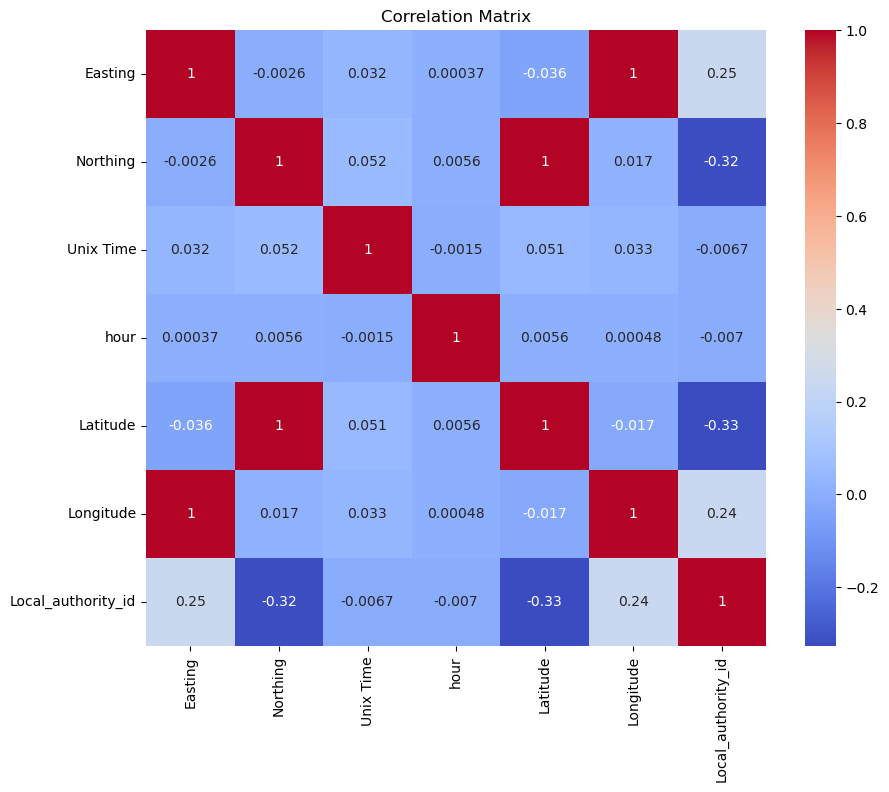

In [272]:
cr = Xcorr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We do see that easting and northings are highly correlated with the latitudes and longitudes. Their effect therefore will be not significant so we remove them as one of our features. 

In [273]:
X_num = X_num.drop(['Easting', 'Northing'], axis=1)

In [274]:
intialize = StandardScaler()
X_num_scaled= intialize.fit_transform(X_num)

encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encode = encoder.fit_transform(X_cat)

In [275]:
encoder = OneHotEncoder(handle_unknown= 'ignore')
Y_encode = encoder.fit_transform(y)

Converting the target variable which is a sparse matrix to a dense array

In [276]:
Y_encode_dense = Y_encode.toarray()

### Splitting the data

The following code is used to convert X_cat_encode to a dense array and then combine the scaled numerical features with the encoded categorical features.

In [277]:
X_cat_encode_dense = X_cat_encode.toarray()
X_combined = np.concatenate((X_num_scaled, X_cat_encode_dense), axis=1)

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y_encode_dense, test_size=0.2, shuffle=False)

In [279]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51859, 11), (12965, 11), (51859, 4), (12965, 4))

The following preprocessing for data is done for logistics regression and random forest

In [280]:
Xrf= mydata[features]
Yrf= mydata[target]

In [281]:
Xrf_dropped= Xrf.drop(['Easting','Northing'],axis=1)

In [282]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf=train_test_split(Xrf_dropped,Yrf, test_size = 0.2, shuffle= False)

In [284]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cols = ['Road_type','Road_category']
transformers = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cols)
    ],
    remainder='passthrough'
)

X_train_rf_encoded = transformer.fit_transform(X_train_rf)
X_test_rf_encoded = transformer.transform(X_test_rf)

We are using columnTransformers in the above, to one hot encode the categorical columns in our features

# Model #1: Multiclass logistics regression

In [285]:
from sklearn.linear_model import LogisticRegression

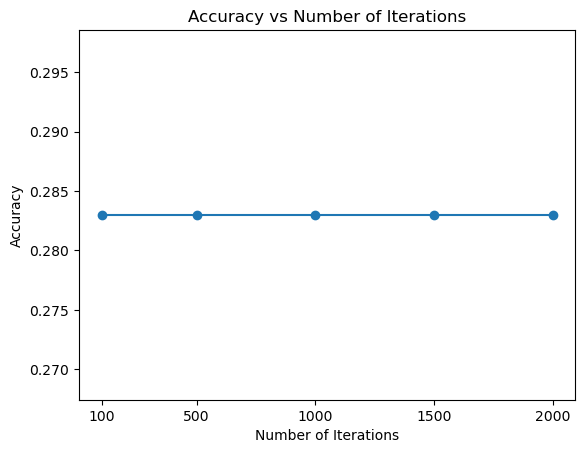

In [286]:
values = [100, 500, 1000, 1500, 2000]
accval=[]

for i in values:
    logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=i)
    logit.fit(X_train_rf_encoded, y_train_rf)
    y_pred = logit.predict(X_test_rf_encoded)
    accuracy = accuracy_score(y_test_rf, y_pred)
    accval.append(accuracy)
    
plt.plot(values,accval,marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Iterations')
plt.xticks(values)

plt.show()

So we see that changing the number of iterations doesnot change the model accuracy. We take max_iter value as 500.

In [287]:
start_time = time.time()
logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
logit.fit(X_train_rf_encoded, y_train_rf)

y_pred = logit.predict(X_test_rf_encoded)
accuracy = accuracy_score(y_test_rf, y_pred)
end_time = time.time()
time_taken = (end_time - start_time)*1000
print("Accuracy:",accuracy)
print("Time Taken:", time_taken)

Accuracy: 0.28299267258002314
Time Taken: 164.06559944152832


# Model #2: Random Forest Model

Random Forest method easily operates for the given dataset by constructing multiple decision trees during training and outputting the mode of the classes (classification) of the individual trees as it is effective in handling high dimensional spaces and large numbers of training examples, and doesn't assume a linear relationship.

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Tuning the random forest for number of trees

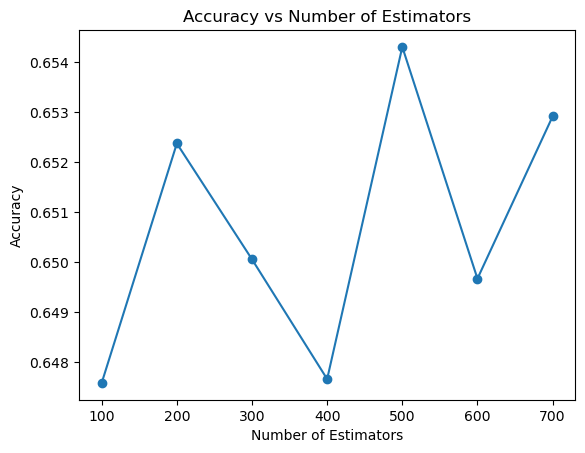

In [291]:
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
n_estimators_results =[]
rf_acc_val=[]
for i in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=i, random_state=0)
    rf.fit(X_train_rf_encoded, y_train_rf)
    y_pred = rf.predict(X_test_rf_encoded)

    accuracy = accuracy_score(y_test_rf, y_pred)
    
    rf_acc_val.append(accuracy)
    n_estimators_results.append(i)
    
plt.plot(n_estimators_results, rf_acc_val, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators')
plt.show()

So we obtain the maximum accuracy at 500 so we take that as our number of tree

### Fitting the Random Forest model 

In [292]:
begin_time = time.time()
classifier = RandomForestClassifier(n_estimators=500, random_state=0)

# Train the classifier on the training data
classifier.fit(X_train_rf_encoded, y_train_rf)

# Make predictions on the test data
ypred = classifier.predict(X_test_rf_encoded)
end_time = time.time()
time_taken_rf = (end_time- begin_time)*1000

# Evaluate the performance of the classifier
accuracy_rf = accuracy_score(y_test_rf, ypred)

print('Accuarcy is:',accuracy_rf)
print('Time taken in milliseconds is: ', time_taken_rf) 

Accuarcy is: 0.6543000385653683
Time taken in milliseconds is:  34562.11066246033


Therefore, it can be concluded that Random Forest performs much better than Support Vector Regressor as its MSE is much smaller than the MSE of SVR which justifies that SVR models are lest efficient on very large datasets.

# Model #4: Artificial Neural Network (ANN)

For the problem at hand, the relationship between different features can be complex and non- linear which can be effectively captured by ANN in addition to its ability to capture the dependance on time which is one of our features. That's why we chose to use this model

In the codes below, we test the ANN model with different learning rates and compare them using the loss on the validation set. This is essentially to tune our learning rate to an optimal value.

In [293]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
lrval=[]
final_val_acc=[]
for lr in learning_rates:
    model = Sequential()
    model.add(Dense(units=11, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=7, activation='relu'))
    model.add(Dense(units=3, activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    pred = model.fit(X_train, y_train, epochs=80, batch_size=64, validation_split=0.2)
    lrval.append(lr)
    final_val_acc.append(pred.history['val_accuracy'][-1])

Epoch 1/80
649/649 [==============================] - 2s 2ms/step - loss: 1.4272 - accuracy: 0.2446 - val_loss: 1.3773 - val_accuracy: 0.3299
Epoch 2/80
649/649 [==============================] - 1s 1ms/step - loss: 1.3841 - accuracy: 0.2837 - val_loss: 1.3613 - val_accuracy: 0.3727
Epoch 3/80
649/649 [==============================] - 1s 1ms/step - loss: 1.3694 - accuracy: 0.3013 - val_loss: 1.3422 - val_accuracy: 0.3909
Epoch 4/80
649/649 [==============================] - 1s 1ms/step - loss: 1.3582 - accuracy: 0.3152 - val_loss: 1.3187 - val_accuracy: 0.3997
Epoch 5/80
649/649 [==============================] - 1s 2ms/step - loss: 1.3467 - accuracy: 0.3229 - val_loss: 1.2942 - val_accuracy: 0.4102
Epoch 6/80
649/649 [==============================] - 1s 1ms/step - loss: 1.3358 - accuracy: 0.3277 - val_loss: 1.2729 - val_accuracy: 0.4093
Epoch 7/80
649/649 [==============================] - 1s 1ms/step - loss: 1.3274 - accuracy: 0.3311 - val_loss: 1.2582 - val_accuracy: 0.4119
Epoch 

- Learning Rate: 0.0001, Final Validation Accuracy: 0.3642
- Learning Rate: 0.001, Final Validation Accuracy:  0.3246
- Learning Rate: 0.01, Final Validation Accuracy: 0.3359
- Learning Rate: 0.1, Final Validation Accuracy: 0.2717
- Learning Rate: 0.5, Final Validation Accuracy: 0.2200

We visualise it as follows:

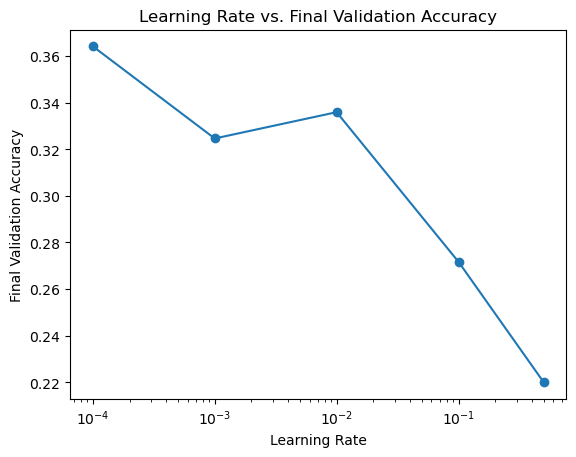

In [294]:
plt.plot(lrval, final_val_acc, marker='o')
plt.xscale('log') #Using a logarithmic scale for better visualization. 
plt.xlabel('Learning Rate')
plt.ylabel('Final Validation Accuracy')
plt.title('Learning Rate vs. Final Validation Accuracy')
plt.show()

Based on these Learning rate values, the learning rate that was chosen for the model is 0.0001

### Model Building

We have the following parameters:
- Units: this is the number of neurons in each layer. input_shape parameter adjusts it based on our dataset further
- ANN models work well with 2-3 hidden layers. We have selected 3 layers.
- The final layer has four neurons and is equal to the number of classes we have
- We chose relu function based on trial and error. Softmax function is used since this is a multiclass classification problem

In [321]:
begin_time= time.time()
finalmodel = Sequential()

# Add the input layer and first hidden layer
finalmodel.add(Dense(units=11, activation='relu'))
finalmodel.add(Dense(units=7, activation='relu'))
finalmodel.add(Dense(units=3, activation='relu'))

# Add the output layer
finalmodel.add(Dense(units=4, activation='softmax'))

# Compile the ANN with the current learning rate
finalmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Model Fitting

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Batch sizes are usually in multiples of 2. Here we have chosen a medium batch size of 64

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. This is usually either 50, 100 or 150 and the value depends on the specific use case.

There are no set guidelines for setting both of these hyperparameters and tuning them would take hours due to the size of our data, so we chose our values based on trial and error and checking the loss + accuracy each time. 

There validation_split parameter is to set aside a percentage of data specified. It will help us to guage how the model performs on datasets other than set on which it is trained. 

We also wish to stop early in case the validation accuracy does not improve for 3 consecutive epoch. The following is our model fitting:

In [322]:
stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
modelfit = finalmodel.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[stop])

Epoch 1/50
649/649 [==============================] - 2s 2ms/step - loss: 1.4547 - accuracy: 0.2226 - val_loss: 1.3778 - val_accuracy: 0.2760
Epoch 2/50
649/649 [==============================] - 1s 1ms/step - loss: 1.3857 - accuracy: 0.2598 - val_loss: 1.3599 - val_accuracy: 0.3128
Epoch 3/50
649/649 [==============================] - 1s 2ms/step - loss: 1.3658 - accuracy: 0.2917 - val_loss: 1.3448 - val_accuracy: 0.3470
Epoch 4/50
649/649 [==============================] - 1s 1ms/step - loss: 1.3510 - accuracy: 0.3142 - val_loss: 1.3235 - val_accuracy: 0.3762
Epoch 5/50
649/649 [==============================] - 1s 1ms/step - loss: 1.3363 - accuracy: 0.3215 - val_loss: 1.2967 - val_accuracy: 0.3858
Epoch 6/50
649/649 [==============================] - 1s 1ms/step - loss: 1.3226 - accuracy: 0.3276 - val_loss: 1.2710 - val_accuracy: 0.3985
Epoch 7/50
649/649 [==============================] - 1s 1ms/step - loss: 1.3124 - accuracy: 0.3312 - val_loss: 1.2534 - val_accuracy: 0.4050
Epoch 

We now plot the accuracy on validation and training set over various epochs.

### Test Loss and Prediction Accuracy

In [323]:
test_loss = finalmodel.evaluate(X_test, y_test)
end_time = time.time()
time_taken = (end_time - begin_time) * 1000

406/406 [==============================] - 1s 1ms/step - loss: 1.2493 - accuracy: 0.4054


Therefore we do find that the accuracy is about 40.54% and the loss is 1.2565. This model works better than naive classification but it's accuracy is still very less.

In [324]:
print("Time Taken in milliseconds:",time_taken)

Time Taken in milliseconds: 25156.139135360718


# Model #5: Long Short-term Memory (LSTM) Model

The LSTM model works well for data which is in the form of a time series. Since we want to predict traffic flow and our model is ordered by time (remember, we did not shuffle the data when splitting it into training and testing sets), we decide to apply this model.

In [312]:
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping

The number of previous time steps we need depends on the type of data we have. Since we have traffic data collected hourly, we decide to set time_steps = 3 which means that the model will take into account the past 3 time steps (i.e. past 3 records of traffic conditions) to predict values. 

We note that data was collected only during the day; so, our data is not spaced uniformly in time and we don't have data for all 24 hours in the day. However, this is a common issue in real-time data and does not explicitly violate any assumptions of the LSTM model; however it could potentially affect the model.

The input data for an LSTM model has to be a 3D vector; thus, we use the reshape() function to prepare our data to be inputted in the right manner for the model to then train on.

In [313]:
time_steps = 3 #the number of previous time steps to be used for prediction

X_train, y_train = np.array(X_train), np.array(y_train)

#We convert our training dataset into input-output pairs that are suitable for the LSTM model.
X1, y1 = [], []
for i in range(len(y_train) - time_steps):
    X1.append(X_train[i:(i + time_steps)].flatten())
    y1.append(y_train[i + time_steps])

X1, y1 = np.array(X1), np.array(y1)

# Reshape input to be [samples, time steps, features]
X1 = X1.reshape((X1.shape[0], time_steps, X_train.shape[1]))

### Model Building 

We have the following parameters:
- Units: this is the number of neurons in an LSTM layer
- Most times, LSTM models work well with 2-3 hidden layers. We have selected 2 layers.
- The dense layer (which is the final output layer, in which each neuron is connected to all the neurons of the previous layer) is given 1 unit, as by trail and error, this gave us the highest level of accuracy
- The learning rate, which can be between 0.01 to 0.0001 

In [314]:
begin_time= time.time()
lstm_model = Sequential() #initialising the model

#Adding 3 LSTM layers
lstm_model.add(LSTM(units=11, return_sequences=True, input_shape=(time_steps, X_train.shape[1])))
lstm_model.add(LSTM(units=11))

lstm_model.add(Dense(1)) #output layer

In [315]:
optimizer = Adam(learning_rate=0.001) 
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy']) #compiling the model

### Fitting the Model

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Batch sizes are usually in multiples of 2.

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. This is usually either 50, 100 or 150 and the value depends on the specific use case.

There are no set guidelines for setting both of these hyperparameters and tuning them would require powerful hardware due to the size of our data, so we chose our values based on trial and error and checking the loss + accuracy each time. 

We also wish to stop early in case the validation accuracy does not improve for 3 consecutive epoch. The following is our model fitting:

In [316]:
stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
lstm_model.fit(X1, y1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[stop])

Epoch 1/50
1297/1297 [==============================] - 7s 4ms/step - loss: 0.1884 - accuracy: 0.7500 - val_loss: 0.1876 - val_accuracy: 0.7500
Epoch 2/50
1297/1297 [==============================] - 4s 3ms/step - loss: 0.1875 - accuracy: 0.7500 - val_loss: 0.1875 - val_accuracy: 0.7500
Epoch 3/50
1297/1297 [==============================] - 4s 3ms/step - loss: 0.1875 - accuracy: 0.7500 - val_loss: 0.1875 - val_accuracy: 0.7500
Epoch 4/50
1297/1297 [==============================] - 4s 3ms/step - loss: 0.1875 - accuracy: 0.7500 - val_loss: 0.1875 - val_accuracy: 0.7500


### Test Loss and Prediction Accuracy

In [317]:
X_test = pd.DataFrame(X_test)

We convert our test dataset into input-output pairs that are suitable for the LSTM model.

In [318]:
X2, y2 = [], []
for i in range(len(y_test) - time_steps):
    X2.append(X_test[i:(i + time_steps)].values.flatten())
    y2.append(y_train[i + time_steps])

X2, y2 = np.array(X2), np.array(y2)

X2 = X2.reshape((X2.shape[0], time_steps, X_test.shape[1])) #reshaping to be able to input it in the LSTM model

In [319]:
test_loss = lstm_model.evaluate(X2, y2) #evaluating the model
end_time = time.time()
time_taken = (end_time - begin_time) * 1000

406/406 [==============================] - 1s 2ms/step - loss: 0.1876 - accuracy: 0.7500


Therefore, the model mean squared error is 0.1880 which can be considered as good, since it is close to zero. The accuracy is 75%.

In [320]:
print("Time Taken in milliseconds:",time_taken)

Time Taken in milliseconds: 21803.654432296753
